# RuCode 6. Определение цвета автомобиля

**Обогащение датасета**

К файлам обучающей выборки добавлены файлы из датасета https://www.kaggle.com/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset
* в каталоге `data/train_extended` помещена копия оригинального обучающего датасета и к ним в папки с цветами добавлены новые файлы
* папки нового датасета 'tan', 'silver', 'pink', 'gold', 'beig' не используются, удалены
* файлы из purple помещены в violet

Полный итоговый контент каталога `data` можно найти здесь: https://disk.yandex.ru/d/s2fpSrgyN5YwVA



**Модель**

Использовалась resnet34 модель из хаба torchvision, предобученная на imagenet.

**Обучение**

Попеременно на простых и аугментированных изображениях. Зубчатый lr.

**Подготовка к запуску**

Скопировать из https://disk.yandex.ru/d/s2fpSrgyN5YwVA сохраненные веса модели и архив датасетов, распаковать архив.

Для запуска на Google Collab код не требует установки дополнительных библиотек.

## Пути

In [1]:
TRAIN_ORIG_PATH = 'data/train'              # оригинальный обучающий датасет
TRAIN_EXTENDED_PATH = 'data/train_extended' # расширенный обучающий датасет
TEST_PUBLIC_PATH =  'data/test'             # публичный (оригинальный) тест   
TEST_PRIVATE_PATH =  'data/test_private'    # приватный тест

In [2]:
TRAIN_PATH = TRAIN_EXTENDED_PATH
TEST_PATH = TEST_PUBLIC_PATH

## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import os
from PIL import Image

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms

In [4]:
from clf_helper import CLF

In [5]:
def seed_everything(seed):
    import os, random
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    
SEED = 42
seed_everything(SEED)

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {DEVICE} mode')

using cuda mode


## Данные

In [7]:
BATCH_SIZE = 128

In [8]:
NORMALIZE = (0.4817, 0.4241, 0.3442), (0.26, 0.2358, 0.2645)

aug_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(*NORMALIZE),
])
basic_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(*NORMALIZE),
])

Обычные train/val лоадеры

In [9]:
full_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform=basic_transform)

train_size = int(len(full_dataset) * 0.8)
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, (train_size, val_size))

loaders = (
    DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=0),
    DataLoader(val_dataset, BATCH_SIZE, shuffle=False, num_workers=0)
)

In [10]:
NUM_CLASSES = len(full_dataset.classes)

лоадеры с аугментацией train

In [11]:
class DatasetTransform(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

full_dataset_notf = torchvision.datasets.ImageFolder(TRAIN_PATH)

train_size = int(len(full_dataset_notf) * 0.8)
val_size = len(full_dataset_notf) - train_size
aug_train_dataset, aug_val_dataset = torch.utils.data.random_split(full_dataset_notf, (train_size, val_size))

aug_train_dataset = DatasetTransform(aug_train_dataset, transform=aug_transform)
aug_val_dataset = DatasetTransform(aug_val_dataset, transform=basic_transform)

aug_loaders = (
    DataLoader(aug_train_dataset, BATCH_SIZE, shuffle=True, num_workers=0),
    DataLoader(aug_val_dataset, BATCH_SIZE, shuffle=False, num_workers=0)
)

Лоадер для test (public или private в зависимости от папки) предсказания.

In [12]:
class TestDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.filenames = os.listdir(TEST_PATH)
        
    def __getitem__(self, index):
        image_path = os.path.join(TEST_PATH, self.filenames[index])
        x = Image.open(image_path)
        y = 0
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.filenames)
    
test_dataset = TestDataset(transform=basic_transform)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=0)

## Описание модели и обучения

Использовал модель resnet34 из хаба pytorch, предобуженную на imagenet. Веса слоев не замораживал, дообучал сразу всю модель. 

Ради эксперимента попробовал обучать в несколько стадий с зубчатым изменением lr. График:

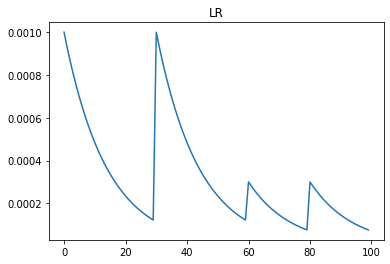

In [13]:
lr_points = []
lr_points.extend([1e-3 * 0.93**i for i in range(30)]) #no_aug
lr_points.extend([1e-3 * 0.93**i for i in range(30)]) #aug
lr_points.extend([3e-4 * 0.93**i for i in range(20)]) #no_aug
lr_points.extend([3e-4 * 0.93**i for i in range(20)]) #aug
plt.title('LR')
plt.plot(lr_points);

При этом обучал попеременно на обычных данных и аугментированных (даталоадеры loaders и aug_loaders). Аугментацию под задачу не подбирал, использовал готовый AutoAugment, который временами не вполне корректно работает с цветом. Подумал что чередование загрузчиков сгладит недостатки аугментации.

**Класс CLF** (файл clf_helper.py) - самописный класс, который осуществляет цикл обучения, визуализацию результата, запись на диск и загрузку чекпоинтов. По примению в коде должно быть достаточно очевидно как используется. 

## Ошибка в коде обработки данных

Уже готовя отчетный текст заметил ошибку при разделении данных. Забыл добавить фиксирование seed при разделении train/val (не добавил параметр `generator=torch.Generator().manual_seed(SEED)` при вызове `torch.utils.data.random_split()`).  Поэтому это разделение оказалось не фиксированным (идентичным) на обычном и аугментировнном загрузчиках. И между ними происходила утечка в val.

**Результат** - завышенная val метрика и немного пониженная тестовая (модель сохранялась по val метрике, а значит не на лучшей эпохе).

## Модель и обучение

In [14]:
model = torchvision.models.resnet34(pretrained=True)
model.fc = nn.Linear(512, NUM_CLASSES, True)

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.93)
clf = CLF(model, optimizer, *aug_loaders, lr_scheduler=lr_scheduler, name='resnet34 augmix pretrain unfrozen', device=DEVICE)

In [16]:
LOAD_FINAL_MODEL = True

In [17]:
def reset_clf_cycle(clf, loaders, lr=3e-4):
    clf.train_loader = loaders[0]
    clf.optimizer = torch.optim.AdamW(clf.model.parameters(), lr=lr)
    clf.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(clf.optimizer, gamma=0.85)
    
    
if LOAD_FINAL_MODEL:
    #clf.load('cp_best_accuracy_submitted.pt')
    clf.load('cp_best_loss_submitted.pt')
else:
    reset_clf_cycle(clf, loaders, 1e-3)
    clf.train(30, plot=True, save_best_loss='cp_best_loss.pt', save_best_accuracy='cp_best_accuracy.pt')
    
    reset_clf_cycle(clf, aug_loaders, 1e-3)
    clf.train(30, plot=True, save_best_loss='cp_best_loss.pt', save_best_accuracy='cp_best_accuracy.pt')

    reset_clf_cycle(clf, loaders, 3e-4)
    clf.train(20, plot=True, save_best_loss='cp_best_loss.pt', save_best_accuracy='cp_best_accuracy.pt')
    
    reset_clf_cycle(clf, aug_loaders, 3e-4)
    clf.train(20, plot=True, save_best_loss='cp_best_loss.pt', save_best_accuracy='cp_best_accuracy.pt')

    clf.save('cp_final.pt')
    clf.load('cp_best_accuracy.pt')

Loaded checkpoint: cp_best_loss_submitted.pt (epoch 86)


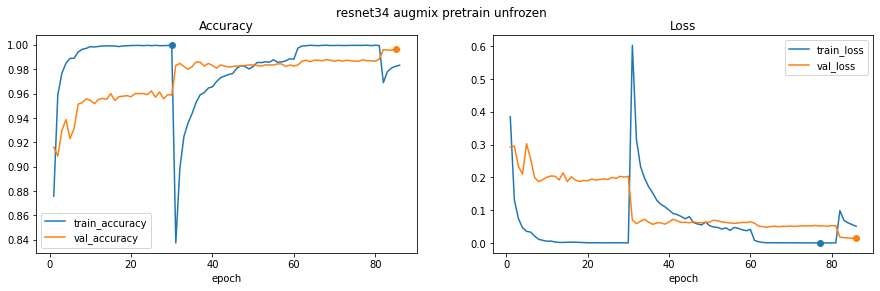

Best val accuracy 99.65% on epoch 85 (138.4 min) | best val loss 0.0146 on epoch 86 (140.4 min)


In [18]:
clf.plot()
clf.stats()

**Комментарий:**

Выглядит интересно, но из-за утечки не так информативно. Эпохи 0-30 и 60-80 - простой датасет, 30-60, 80-100 - аугментированный. Последняя эпоха меньше 100, поскольку это загруженный чекпоинт, сохраненый по максимуму val_accuracy или val_loss.

Как видно итоговая val accuracy оказалась завышенной - аж 99.65%. Рост val метрики и падение val loss на 30,80 эпохе и связан с тем, что часть train объектов оказалось в val. Когда заметил переделывать было поздно. Скачок train loss там же - из-за начала работы с аугментироанным датасетом. 

В целом несмотря на это модель обучилась адекватно. На полученном чекпоинте модель дала скор **0.9812 на публичном тесте** и **0.9830 на приватном тесте**.

На моделях, обученных раздельно на простых и аугментированных лоадерах был и более высокий паблик скор - **0.9857**. Но засмотрелся на "прекрасные" валидационные метрики и сдал этот вариант.

## Предсказание на test выборке и экспорт

In [19]:
classes = full_dataset.classes
filenames = test_dataset.filenames

preds = clf.predict(test_loader)
preds_labels = [classes[x] for x in preds]

Не забыть отсортировать файлы как числа.

In [20]:
df_result = pd.DataFrame({'id': [int(s.split('.')[0]) for s in filenames],
                          'filename': filenames,
                          'label': preds_labels})
df_result = df_result.sort_values('id').set_index('id')

In [21]:
filename = 'submission.csv'

with open(filename, 'w') as f:
    result_str = '\n'.join(df_result.label.values.tolist())
    f.write(result_str)

In [22]:
df_result

,filename,label
id,,
0,0.jpg,Violet
1,1.jpg,White
2,2.jpg,Yellow
3,3.jpg,Grey
4,4.jpg,Green
...,...,...
1431,1431.jpg,Yellow
1432,1432.jpg,Black
1433,1433.jpg,Cyan
